# Data Preparation

## installing the necessary libraries.

In [1]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.17.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.4 MB/s eta 0:00:00
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.4 MB/s eta 0:00:00
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninsta

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim



## Loading the dataset from an Excel file and performing necessary preprocessing

In [55]:
# data = pd.read_excel('4A_TB_cleaned.xlsx')
data = pd.read_csv('/content/TB_Analysis (1).csv')
data.head()

,UNIT,IP NUMBER,SEX,AGE,RELIGION,DISTRICT OF RESIDENCE,WORKING DIAGNOSIS,OUT COME,NUMBER OF PREVIOUS ADMISSIONS,TB_type,MARITAL STATUS,MONTH OF ADMISSION,DAY OF ADMISSION,YEAR OF ADMISSION,DURATION,REGION,ADDITIONAL WORKING DIAGNOSIS,NUMBER OF ADDITIONAL WORKING DIAGNOSIS
0,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1
1,GI,1868011,F,46,COU,Kampala,"ISS Stage I&II,Disseminated TB,,",IMPROVED,3,Disseminated TB,2,December,Monday,2010,4,CENTRAL,"ISS Stage I&II,,",1
2,GI,1868840,M,80,ISLAM,Wakiso,"myeloproliferat,Malaria,INTESTINAL TB,",IMPROVED,7,Abdominal_TB,4,December,Wednesday,2010,8,CENTRAL,"myeloproliferat,Malaria,",2
3,GI,1851080,M,22,CATHOLIC,KAMPALA,"Abd TB,,,",IMPROVED,8,Abdominal_TB,9,December,Monday,2010,9,CENTRAL,",,",0
4,GI,1870478,F,18,COU,KAMPALA,"PTB,,,",IMPROVED,4,PTB,1,January,Thursday,2011,5,CENTRAL,",,",0


In [56]:
# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1
    else:
        return 0


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)

In [21]:

# # Filter the data
# data = data[~((data['OUT COME'] != 'DIED') & (data['DURATION'] < 7))]


In [22]:


# filtered_data = data[((data['OUT COME'] != 'DIED') & (data['DURATION'] < 7))]
# if len(filtered_data) > 0:
#   print("There are rows with 'OUT COME' != 'DIED' and duration less than 28 days.")
# else:
#   print("No rows found with 'OUT COME' != 'DIED' and duration less than 28 days.")


In [57]:


data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME'], inplace=True)

new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION', 'SURVIVAL']
data = data[new_col_order]

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.shape

(4092, 12)

In [58]:
data['SURVIVAL'].value_counts()

,count
SURVIVAL,
0,2781
1,1311


In [59]:
data.head()

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,SURVIVAL
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
1,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0
2,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,0
3,M,22,CATHOLIC,CENTRAL,0,Abdominal_TB,8,Monday,December,2010,9,0
4,F,18,COU,CENTRAL,0,PTB,4,Thursday,January,2011,5,0


In [60]:
data.isnull().sum()


,0
SEX,0
AGE,0
RELIGION,0
REGION,0
NUMBER OF ADDITIONAL WORKING DIAGNOSIS,0
TB_type,0
NUMBER OF PREVIOUS ADMISSIONS,0
DAY OF ADMISSION,0
MONTH OF ADMISSION,0
YEAR OF ADMISSION,0


## Encoding Categorical Features and Standardizing Continuous Features

In [61]:


# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

dataset = pd.get_dummies(data, columns=categorical_features)
dataset = dataset.astype(int)
dataset.head()

#Standardizing continuous features
standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
scaler = StandardScaler()
dataset[standardize_features] = scaler.fit_transform(dataset[standardize_features])
dataset.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,SURVIVAL,Month of Admission,Day of Admission,SEX_F,SEX_M,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1.010431,-0.700413,0.353972,2010,-0.559238,0,1.626162,-0.413998,1,0,...,0,0,0,0,0,0,1,0,0,0
2,4.170011,0.597635,1.304868,2010,-0.046086,0,1.626162,-0.323601,0,1,...,0,0,0,0,1,0,0,0,0,0
3,-1.219861,-1.998462,1.542592,2010,0.082202,0,1.626162,-0.413998,0,1,...,0,0,0,0,1,0,0,0,0,0
4,-1.591577,-1.998462,0.591696,2011,-0.430950,0,-1.576218,-0.278403,1,0,...,0,0,0,0,0,0,0,0,1,0


In [62]:
dataset['SURVIVAL'].value_counts()

,count
SURVIVAL,
0,2781
1,1311


In [13]:
#dataset.to_csv('TB_Analysis.csv', index=False)

## split

In [63]:

from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Further split the train data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=42)

# Define X, T, and E for each set
X_train = train_data.drop(['SURVIVAL', 'DURATION'], axis=1)
T_train = train_data['DURATION']
E_train = train_data['SURVIVAL']

X_val = val_data.drop(['SURVIVAL', 'DURATION'], axis=1)
T_val = val_data['DURATION']
E_val = val_data['SURVIVAL']

X_test = test_data.drop(['SURVIVAL', 'DURATION'], axis=1)
T_test = test_data['DURATION']
E_test = test_data['SURVIVAL']

In [15]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # Create a SMOTE instance
# smote = SMOTE(random_state=123)

# # Fit and transform the training data
# X_smote, y_smote = smote.fit_resample(X_train1, E_train)
# X_train = X_smote.drop(['DURATION'], axis=1)
# T_train = X_smote['DURATION']
# print('Original dataset shape:', Counter(E_train))
# print('Resampled dataset shape:', Counter(y_smote))

In [64]:
# E_train = y_smote
E_train.value_counts()

,count
SURVIVAL,
0,1542
1,749


In [31]:
print(X_train)


           AGE  NUMBER OF ADDITIONAL WORKING DIAGNOSIS  \
271  -0.290573                                0.597635   
4038 -0.104715                                0.597635   
2190  1.568004                                0.597635   
754  -0.476431                               -0.700413   
2343  0.359929                               -0.700413   
...        ...                                     ...   
1624 -0.011786                                0.597635   
2284  0.081142                               -0.700413   
3950  1.382146                               -0.700413   
57   -0.290573                               -0.700413   
1500  0.638715                               -0.700413   

      NUMBER OF PREVIOUS ADMISSIONS  YEAR OF ADMISSION  Month of Admission  \
271                        1.067144               2012           -1.576218   
4038                      -0.359200               2019            0.170535   
2190                      -0.359200               2015           -0.4

In [32]:
train_data.shape

(2291, 26)

In [33]:
test_data.shape

(819, 26)

In [34]:
val_data.shape

(982, 26)

# Train

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, dropout=0.2, initializer='glorot_uniform', output_activation=None):
        super(NeuralNet, self).__init__()
        self.initializer = initializer
        self.input_dim = input_dim
        self.output_dim = output_dim
        layers = []
        in_dim = input_dim

        for layer in hidden_layers:
            linear_layer = nn.Linear(in_dim, layer['num_units'])
            self.init_weights(linear_layer)  # Initialize the weights
            layers.append(linear_layer)

            if layer['activation'] == 'ReLU':
                layers.append(nn.ReLU())
            elif layer['activation'] == 'Tanh':
                layers.append(nn.Tanh())

            # Add more activations as needed
            layers.append(nn.Dropout(dropout))
            in_dim = layer['num_units']

        final_layer = nn.Linear(in_dim, output_dim)
        self.init_weights(final_layer)  # Initialize the final layer
        layers.append(final_layer)

        # Output activation function
        if output_activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif output_activation == 'softmax':
            layers.append(nn.Softmax(dim=1))
        elif output_activation == 'relu':
            layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)

    def init_weights(self, layer):
        """Apply initialization to layers based on the specified initializer."""
        if self.initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(layer.weight)
        elif self.initializer == 'glorot_normal':
            nn.init.xavier_normal_(layer.weight)
        elif self.initializer == 'kaiming_uniform':
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        elif self.initializer == 'kaiming_normal':
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        else:
            raise ValueError(f"Initializer '{self.initializer}' not supported.")


    def forward(self, x):
        return self.network(x)

# Define custom MTLR model with the correct loss function
class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.loss_values = []
        self.bins = bins
        self.structure = structure
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = max(T)
        min_time = 0 if is_min_time_zero else min(T)
        p = extra_pct_time
        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.num_times = len(self.times) - 1
        self.time_buckets = [(self.times[i], self.times[i+1]) for i in range(len(self.times)-1)]

    def compute_XY(self, X, T, E, is_min_time_zero=True, extra_pct_time=0.1):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            index = np.argmin([abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets])

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[(index):] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        X_cens, X_uncens = torch.FloatTensor(X_cens), torch.FloatTensor(X_uncens)
        Y_cens, Y_uncens = torch.FloatTensor(Y_cens), torch.FloatTensor(Y_uncens)
        return X_cens, X_uncens, Y_cens, Y_uncens

    def norm_diff(self, W):
        """ Special norm function for the last layer of the MTLR """
        dims=len(W.shape)
        if dims==1:
            diff = W[1:]-W[:-1]
        elif dims==2:
            diff = W[1:, :]-W[:-1, :]
        return torch.sum(diff*diff)

    def loss_function(self, model, X_cens, X_uncens, Y_cens, Y_uncens, Triangle, l2_reg, l2_smooth):
        score_uncens = model(X_uncens)
        phi_uncens = torch.exp(torch.mm(score_uncens, Triangle))
        reduc_phi_uncens = torch.sum(phi_uncens * Y_uncens, dim=1)

        score_cens = model(X_cens)
        phi_cens = torch.exp(torch.mm(score_cens, Triangle))
        reduc_phi_cens = torch.sum(phi_cens * Y_cens, dim=1)

        z_uncens = torch.exp(torch.mm(score_uncens, Triangle))
        reduc_z_uncens = torch.sum(z_uncens, dim=1)

        z_cens = torch.exp(torch.mm(score_cens, Triangle))
        reduc_z_cens = torch.sum(z_cens, dim=1)

        loss = - (
            torch.sum(torch.log(reduc_phi_uncens)) +
            torch.sum(torch.log(reduc_phi_cens)) -
            torch.sum(torch.log(reduc_z_uncens)) -
            torch.sum(torch.log(reduc_z_cens))
        )

        # Adding the regularized loss
        nb_set_parameters = len(list(model.parameters()))
        for i, w in enumerate(model.parameters()):
            loss += l2_reg*torch.sum(w*w)

            if i >= nb_set_parameters - 2:
                loss += l2_smooth*self.norm_diff(w)

        return loss



    def fit(self, X_train, T_train, E_train, X_val, T_val, E_val,
        init_method='glorot_uniform', optimizer='adam', lr=1e-5,
        num_epochs=1000, dropout=0.5, l2_reg=1e-2, l2_smooth=1e-2,
        batch_normalization=False, bn_and_dropout=True, verbose=True,
        extra_pct_time=0.1, is_min_time_zero=True, initializer='glorot_uniform', output_activation='sigmoid'):
      """
      Fit the estimator with both training and validation sets.
      """
      # Initialize attributes
      self.loss_values = []
      self.val_loss_values = []

      # Extracting data parameters
      nb_units, self.num_vars = X_train.shape
      input_shape = self.num_vars

      # Scaling data
      if self.auto_scaler:
          X_train = self.scaler.fit_transform(X_train)
          X_val = self.scaler.transform(X_val)

      # Build the time axis, time buckets, and output Y for both training and validation
      X_cens_train, X_uncens_train, Y_cens_train, Y_uncens_train = self.compute_XY(X_train, T_train, E_train, is_min_time_zero, extra_pct_time)
      X_cens_val, X_uncens_val, Y_cens_val, Y_uncens_val = self.compute_XY(X_val, T_val, E_val, is_min_time_zero, extra_pct_time)

      # Initialize the model
      model = NeuralNet(input_shape, self.num_times, self.structure, dropout, initializer, output_activation)

      # Create the Triangular matrix
      Triangle = np.tri(self.num_times, self.num_times + 1, dtype=np.float32)
      Triangle = torch.FloatTensor(Triangle)

      # Initialize optimizer (changed here)
      if optimizer == 'adam':
          optimizer = optim.Adam(model.parameters(), lr=lr)
      elif optimizer == 'sgd':
          optimizer = optim.SGD(model.parameters(), lr=lr)
      else:
          raise ValueError(f"Unknown optimizer: {optimizer}")

      # Training loop
      for epoch in range(num_epochs):
          model.train()  # Set model to training mode

          # Compute training loss
          loss_train = self.loss_function(model, X_cens_train, X_uncens_train, Y_cens_train, Y_uncens_train, Triangle, l2_reg, l2_smooth)
          self.loss_values.append(loss_train.item())

          # Perform a forward pass on the validation data
          model.eval()  # Set model to evaluation mode
          with torch.no_grad():
              loss_val = self.loss_function(model, X_cens_val, X_uncens_val, Y_cens_val, Y_uncens_val, Triangle, l2_reg, l2_smooth)
          self.val_loss_values.append(loss_val.item())

          # Gradient update
          optimizer.zero_grad()
          loss_train.backward()
          optimizer.step()

          # Logging
          if verbose and (epoch % 100 == 0 or epoch == num_epochs - 1):
              print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')

      self.model = model.eval()
      return self.model

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss')
        plt.plot(self.val_loss_values, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, x, t=None):
        """ Predicting the hazard, density and survival functions """

        # Transform to PyTorch tensor
        x = torch.FloatTensor(x)

        # Predict using the trained model
        score_torch = self.model(x)
        score = score_torch.data.numpy()

        # Creating time triangles
        Triangle1 = np.tri(self.num_times, self.num_times + 1)
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        # Calculate score, density, hazard, and survival
        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        # Return full functions or predictions at time t
        if t is None:
            return hazard, density, Survival
        else:
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)
            return hazard[:, index], density[:, index], Survival[:, index]


    def evaluate(self, X, T, E):
        """
        Evaluate the model using the concordance index and integrated Brier score.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.

        Returns:
        float: Concordance index, Integrated Brier score.
        """
        # Scale the features
        if self.auto_scaler:
            X = self.scaler.transform(X)

        # Get predictions
        _, _, Survival = self.predict(X)

        # Calculate concordance index
        c_index = concordance_index_censored(E.astype(bool), T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        # Binary classification at a chosen threshold (e.g., 0.5)
        risk_threshold = 0.5
        predicted_events = (Survival[:, -1] > risk_threshold).astype(int)

        # Accuracy
        accuracy = accuracy_score(E, predicted_events)

        # ROC Curve and AUC
        fpr, tpr, thresholds = roc_curve(E, Survival[:, -1])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        self.plot_roc_curve(fpr, tpr, roc_auc)

        # Confusion Matrix
        conf_matrix = confusion_matrix(E, predicted_events)
        self.plot_confusion_matrix(conf_matrix)

        # Plot Brier Score and Actual vs. Predicted Events
        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, Survival)

        return c_index, integrated_brier_score, accuracy, roc_auc

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        """Plot the Brier score curve."""
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, Survival):
        """Plot the actual vs. predicted number of events over time."""
        time_grid = np.linspace(0, T.max(), 100)
        actual_events = np.array([(T >= t).sum() for t in time_grid])
        predicted_events = np.array([(Survival[:, :-1] >= t).sum() for t in time_grid])

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, actual_events, label='Actual', color='red')
        plt.plot(time_grid, predicted_events, label='Predicted', color='blue')
        plt.fill_between(time_grid, predicted_events - 1.96 * np.sqrt(predicted_events),
                         predicted_events + 1.96 * np.sqrt(predicted_events), color='blue', alpha=0.2,
                         label='Confidence Intervals')
        plt.title('Actual vs Predicted Number of Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_roc_curve(self, fpr, tpr, roc_auc):
        """
        Plot the ROC curve.

        Parameters:
        fpr (np.ndarray): False positive rates.
        tpr (np.ndarray): True positive rates.
        roc_auc (float): Area under the ROC curve.
        """
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, cm):
        """
        Plot the confusion matrix.

        Parameters:
        cm (np.ndarray): Confusion matrix.
        """
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['No Event', 'Event'], rotation=45)
        plt.yticks(tick_marks, ['No Event', 'Event'])

        thresh = cm.max() / 2.0
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()




Epoch 1/10000, Training Loss: 617.8718, Validation Loss: 286.6667
Epoch 101/10000, Training Loss: 409.5053, Validation Loss: 206.1452
Epoch 201/10000, Training Loss: 407.1719, Validation Loss: 205.3150
Epoch 301/10000, Training Loss: 403.9043, Validation Loss: 203.4779
Epoch 401/10000, Training Loss: 388.9313, Validation Loss: 202.2487
Epoch 501/10000, Training Loss: 386.2749, Validation Loss: 201.7314
Epoch 601/10000, Training Loss: 385.2651, Validation Loss: 201.7705
Epoch 701/10000, Training Loss: 384.3578, Validation Loss: 201.4864
Epoch 801/10000, Training Loss: 383.6895, Validation Loss: 201.7373
Epoch 901/10000, Training Loss: 383.2008, Validation Loss: 201.6129
Epoch 1001/10000, Training Loss: 382.8252, Validation Loss: 201.4675
Epoch 1101/10000, Training Loss: 382.5278, Validation Loss: 201.3188
Epoch 1201/10000, Training Loss: 382.2885, Validation Loss: 201.1765
Epoch 1301/10000, Training Loss: 382.0902, Validation Loss: 201.0471
Epoch 1401/10000, Training Loss: 381.9253, Val

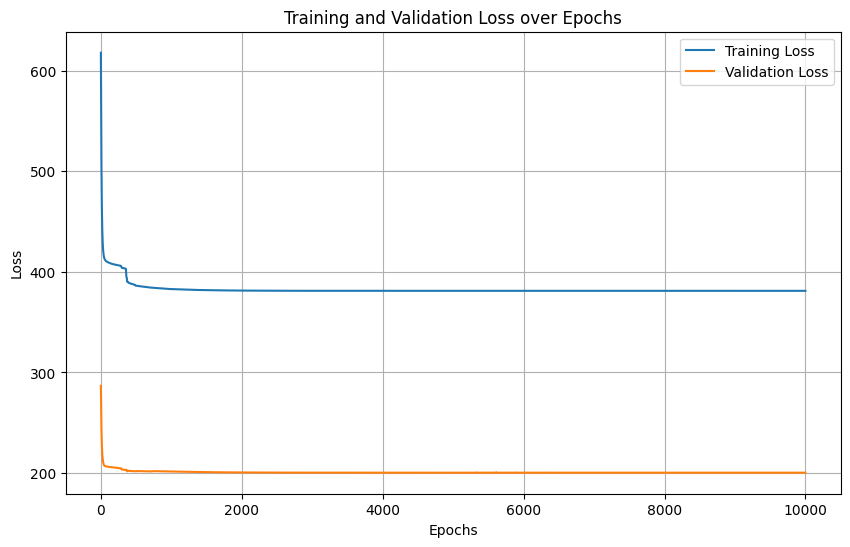

In [95]:
# Create MTLR object with the necessary parameters
structure = [{'activation': 'tanh', 'num_units': 128}, {'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=4)

# Fit the model with training and validation data
model.fit(
    X_train=X_train,
    T_train=T_train,
    E_train=E_train,
    X_val=X_val,
    T_val=T_val,
    E_val=E_val,
    num_epochs=10000,
    optimizer='adam',
    lr=1e-3,
    init_method='glorot_uniform',
    output_activation='sigmoid',
    dropout=0.0,
    l2_reg=1e-1,
    l2_smooth=1e-1,
    batch_normalization=True,
    bn_and_dropout=True,
    verbose=True
)

# Plot the training and validation loss curves
model.plot_loss()


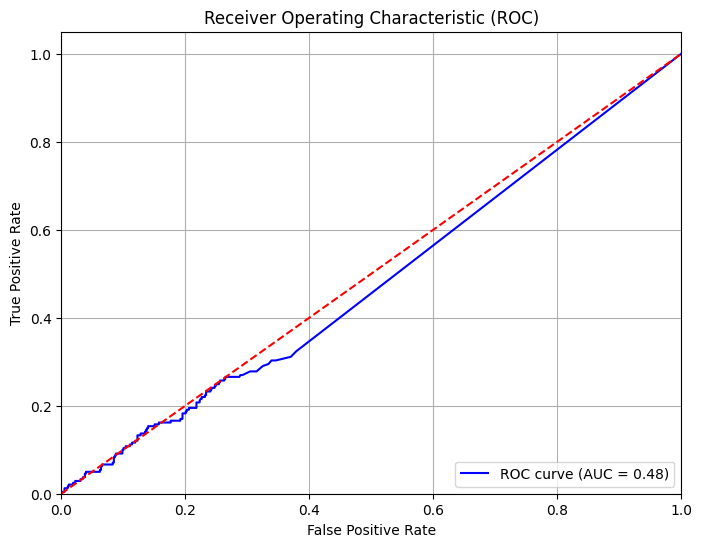

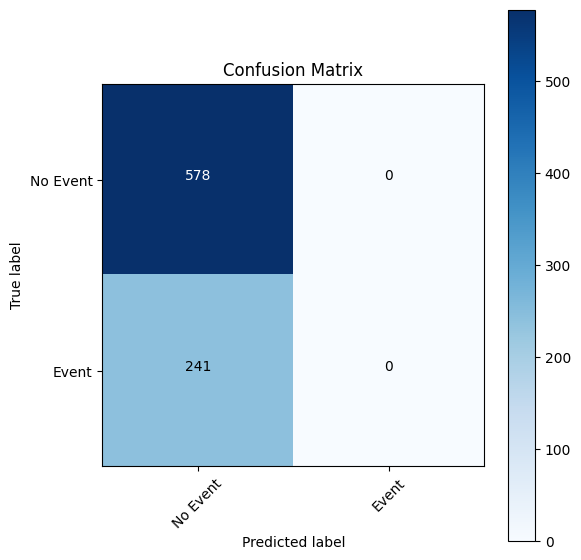

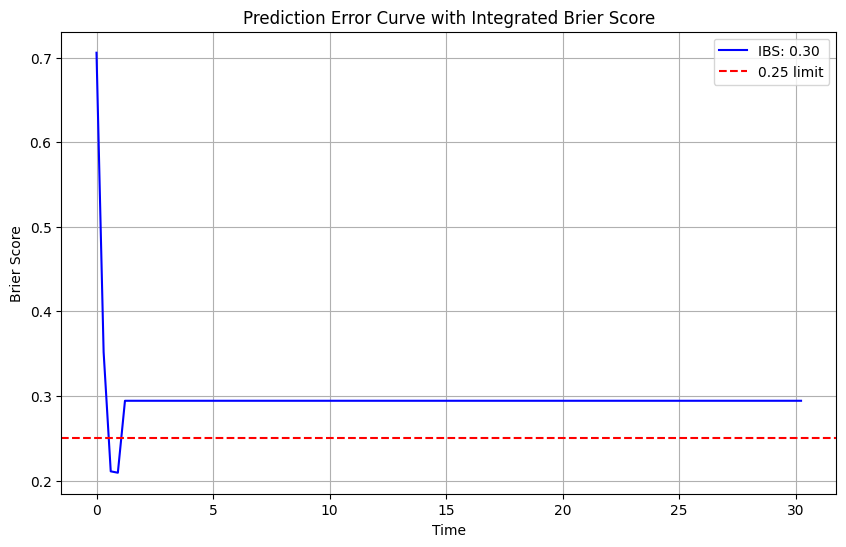

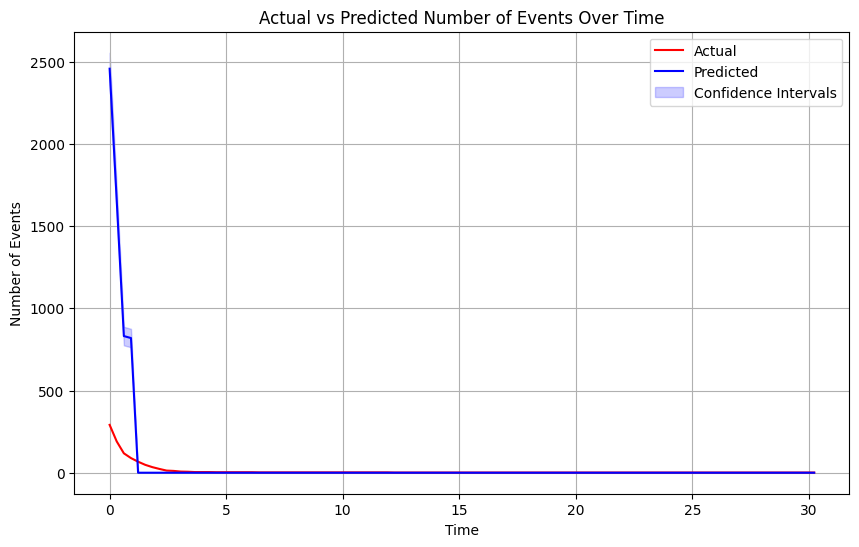

Concordance Index: 0.5346
Integrated Brier Score: 0.2952
Accuracy: 0.7057
ROC AUC: 0.4780


In [96]:
c_index, integrated_brier_score, accuracy, roc_auc= model.evaluate(X_test, T_test, E_test)

print(f'Concordance Index: {c_index:.4f}')
print(f'Integrated Brier Score: {integrated_brier_score:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

In [97]:
# Make predictions (example)
_, density, Survival = model.predict(X_test.values[:5])
print(Survival)


[[1.   0.75 0.5  0.25]
 [1.   0.75 0.5  0.25]
 [1.   0.75 0.5  0.25]
 [1.   0.75 0.5  0.25]
 [1.   0.75 0.5  0.25]]


In [98]:
print(density)

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
